In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c

epoch = np.datetime64('2015-12-31T16:00:00', 'us')
Xband_freq = 8431e6

In [2]:
def open_state(path, sel = slice(None)):
    with open(path) as f:
        lines = f.readlines()[sel]
    t = np.array([epoch + np.timedelta64(int(a.split()[0].lstrip('[').rstrip(']'), 16) * 100, 'us')
            for a in lines])
    x = np.array([[float(x) for x in a.split()[3:]] for a in lines])
    return t, x

t, x = open_state('tm_state_vectors/20200801')

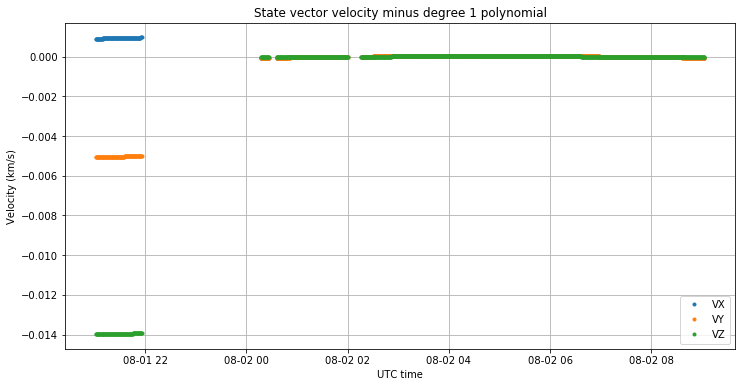

In [3]:
jump = np.argmax(np.diff(t))+1
s = (t-t[0])/np.timedelta64(1,'s')
dv = np.empty_like(x[:,3:])
for j in range(3,6):
    p = np.polyfit(s[jump+1:], x[jump+1:,j], 1)
    dv[:,j-3] = x[:,j] - np.polyval(p, s)
    
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t, dv, '.')
plt.title('State vector velocity minus degree 1 polynomial')
plt.grid()
plt.xlabel('UTC time')
plt.legend(['VX', 'VY', 'VZ'])
plt.ylabel('Velocity (km/s)');

In [4]:
delta_v = -dv[jump-1]*1e3
delta_v

array([-0.96498824,  5.00862308, 13.94448455])

In [5]:
delta_v_norm = np.sqrt(np.sum(delta_v**2))
delta_v_norm

14.848102803753614

In [6]:
# Sun ICRF just before TCM-1
#        Time System   Gregorian                     Modified Julian  
#        ----------------------------------------------------------------------    
#        UTC Epoch:    01 Aug 2020 22:56:38.636      29063.4560027315
#        TAI Epoch:    01 Aug 2020 22:57:15.636      29063.4564309722
#        TT  Epoch:    01 Aug 2020 22:57:47.820      29063.4568034722
#        TDB Epoch:    01 Aug 2020 22:57:47.819      29063.4568034634
#
#        Cartesian State                       Keplerian State
#        ---------------------------           -------------------------------- 
#        X  =   100106665.12599 km             SMA  =   196395473.11311 km
#        Y  =  -106233036.89143 km             ECC  =   0.2264074114545
#        Z  =  -45482379.221828 km             INC  =   23.985734539291 deg
#        VX =   25.601134853241 km/sec         RAAN =   357.75144052004 deg
#        VY =   18.216911054279 km/sec         AOP  =   297.97429611023 deg
#        VZ =   8.5459278889407 km/sec         TA   =   14.988135302053 deg
#                                              MA   =   9.2475726826253 deg
#                                              EA   =   11.928893048680 deg 

V = np.array([25.601134853241, 18.216911054279, 8.5459278889407])
V = V / np.sqrt(np.sum(V**2))
R = np.array([100106665.12599, -106233036.89143, -45482379.221828])
N = np.cross(V,-R)
N = N / np.sqrt(np.sum(N**2))
B = np.cross(V,N)
VNB_rot = np.stack((V,N,B), axis = 1)

In [7]:
delta_V_VNB = VNB_rot.T @ delta_v
delta_V_VNB

array([ 5.70307085, 10.72123959, -8.54377911])

In [8]:
# Earth ICRF just before TCM-1
#        Time System   Gregorian                     Modified Julian  
#        ----------------------------------------------------------------------    
#        UTC Epoch:    01 Aug 2020 22:56:38.636      29063.4560027315
#        TAI Epoch:    01 Aug 2020 22:57:15.636      29063.4564309722
#        TT  Epoch:    01 Aug 2020 22:57:47.820      29063.4568034722
#        TDB Epoch:    01 Aug 2020 22:57:47.819      29063.4568034634
#
#        Cartesian State                       Keplerian State
#        ---------------------------           -------------------------------- 
#        X  =   2824896.0703325 km             SMA  =  -33739.791145906 km
#        Y  =   703882.11955762 km             ECC  =   1.0100269372188
#        Z  =   874648.20443903 km             INC  =   19.719676923581 deg
#        VX =   3.2283744901454 km/sec         RAAN =   250.93957110112 deg
#        VY =   0.8099034875800 km/sec         AOP  =   309.65888221948 deg
#        VZ =   0.9989315603252 km/sec         TA   =   171.83014107664 deg
#                                              MA   =   4921.4382033189 deg
#                                              HA   =   297.65460113930 deg

Rearth = np.array([2824896.0703325, 703882.11955762, 874648.20443903])
delta_v_proj = np.dot(delta_v, Rearth)/np.sqrt(np.sum(Rearth**2))
delta_v_proj

4.275257401691603

In [9]:
with open('peakreclog020820.txt') as f:
    lines = f.readlines()
t_peakrec = np.array([np.datetime64('T'.join(l.split()[:2])) for l in lines])
f_peakrec = np.array([float(l.split()[2]) for l in lines])

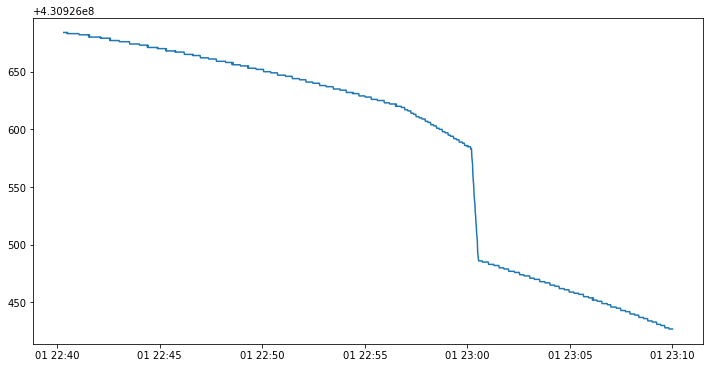

In [10]:
sel = (t_peakrec >= np.datetime64('2020-08-01T22:30')) & (t_peakrec <= np.datetime64('2020-08-01T23:10'))
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_peakrec[sel], f_peakrec[sel])

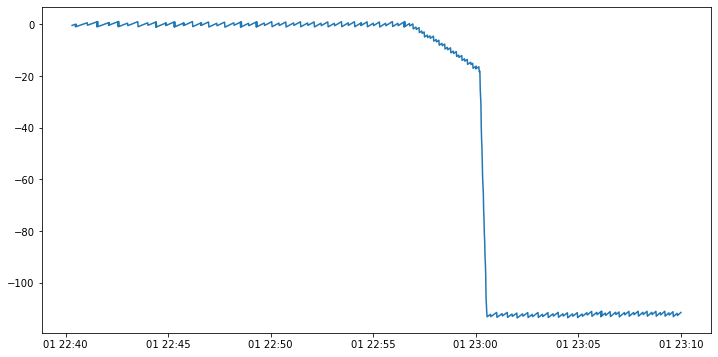

In [11]:
sel_fit = t_peakrec <= np.datetime64('2020-08-01T22:55')
s = (t_peakrec-t_peakrec[0])/np.timedelta64(1,'s')
p_peakrec = np.polyfit(s[sel & sel_fit], f_peakrec[sel & sel_fit], 2)
f_peakrec_corr = f_peakrec - np.polyval(p_peakrec, s)
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_peakrec[sel], f_peakrec_corr[sel])

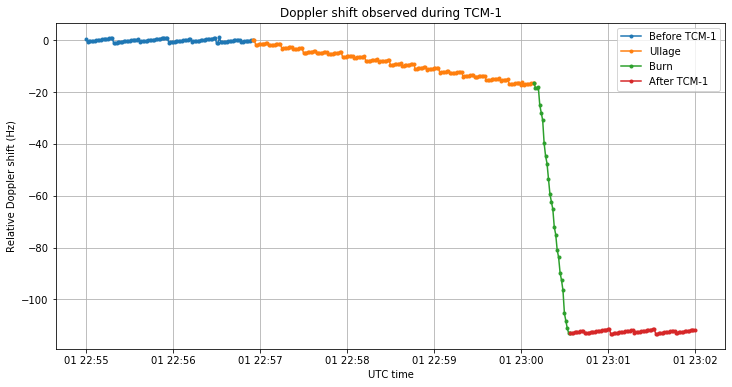

In [12]:
sel_before = (t_peakrec >= np.datetime64('2020-08-01T22:55')) & (t_peakrec <= np.datetime64('2020-08-01T22:56:55'))
sel_ullage = (t_peakrec >= np.datetime64('2020-08-01T22:56:55')) & (t_peakrec <= np.datetime64('2020-08-01T23:00:09'))
sel_burn = (t_peakrec >= np.datetime64('2020-08-01T23:00:09')) & (t_peakrec <= np.datetime64('2020-08-01T23:00:34'))
sel_after = (t_peakrec >= np.datetime64('2020-08-01T23:00:34')) & (t_peakrec <= np.datetime64('2020-08-01T23:02'))

plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_peakrec[sel_before], f_peakrec_corr[sel_before], '.-', label = 'Before TCM-1')
plt.plot(t_peakrec[sel_ullage], f_peakrec_corr[sel_ullage], '.-', label = 'Ullage')
plt.plot(t_peakrec[sel_burn], f_peakrec_corr[sel_burn], '.-', label = 'Burn')
plt.plot(t_peakrec[sel_after], f_peakrec_corr[sel_after], '.-', label = 'After TCM-1')
plt.legend()
plt.grid()
plt.title('Doppler shift observed during TCM-1')
plt.xlabel('UTC time')
plt.ylabel('Relative Doppler shift (Hz)');

In [13]:
total_shift = f_peakrec_corr[sel_after][-1]
total_shift

-111.68599164485931

In [14]:
ullage_shift = f_peakrec_corr[sel_ullage][-1]
ullage_shift

-16.40932196378708

In [15]:
burn_shift = total_shift - ullage_shift
burn_shift

-95.27666968107224

In [16]:
ullage_shift/total_shift

0.14692372536714965

In [17]:
ullage_time = t_peakrec[sel_ullage][-1] - t_peakrec[sel_ullage][0]
ullage_time

numpy.timedelta64(194,'s')

In [18]:
burn_time = t_peakrec[sel_burn][-1] - t_peakrec[sel_burn][0]
burn_time

numpy.timedelta64(25,'s')

In [19]:
ullage_drift = np.polyfit(s[sel_ullage], f_peakrec_corr[sel_ullage], 1)[0]
ullage_drift

-0.08591914664445155

In [20]:
burn_drift = np.polyfit(s[sel_burn], f_peakrec_corr[sel_burn], 1)[0]
burn_drift

-4.3574757328196085

In [21]:
-delta_v_proj/c * Xband_freq

-120.2321612562445

In [22]:
-delta_v_norm/delta_v_proj * burn_drift/Xband_freq * c

0.5381276271652051

In [23]:
# Burn of 3kN quoted in http://www.spaceflightfans.cn/78053.html#more-78053
F = 3000
m = 5000
F/m

0.6

In [24]:
ullage_accel = -delta_v_norm/delta_v_proj * ullage_drift/Xband_freq * c
ullage_accel

0.010610607917699234

In [25]:
ullage_accel * m

53.05303958849617